In [3]:
# Models
from lightgbm import LGBMRegressor

# Model selection
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.metrics import r2_score, mean_absolute_error

# Model tuning
from functools import partial
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hyperopt.pyll.base import scope

# Data handling
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Feature handling
from sklearn.preprocessing import StandardScaler, RobustScaler, SplineTransformer, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

# Math
import numpy as np

# Display
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

In [4]:
train_data = pd.read_csv('train.csv', index_col=0).sort_index()
test_data = pd.read_csv('test.csv', index_col=0).sort_index()

In [5]:
train_data.sample(5)

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Energy city
48221,11/30/2021/20:50,17.7366,75.70,0.08652,0.037,0.122,81004.200640
13110,04/01/2021/01:00,18.0971,85.30,0.07004,0.037,0.119,56970.362229
3271,01/22/2021/17:10,17.2319,56.13,0.08755,175.100,220.400,77279.946477
42393,10/21/2021/09:30,21.5682,87.60,5.06039,315.900,49.210,58521.263861
29263,07/22/2021/05:10,24.7818,48.48,5.05421,0.066,0.152,60546.173563


In [6]:
test_data.sample(5)

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Energy city
19482,05/15/2021/07:00,20.7339,79.00,5.06657,42.690,36.690,0
41657,10/16/2021/06:50,21.1974,92.90,0.07313,0.084,0.085,0
19442,05/15/2021/00:20,20.5588,85.90,5.06863,0.066,0.126,0
51027,12/20/2021/08:30,18.5709,69.53,0.07725,1.760,1.861,0
41046,10/12/2021/01:00,20.2498,72.40,0.12360,0.058,0.137,0


In [80]:
class DataPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, transform_train=True):
        self.transform_train = transform_train

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X.copy()
        X_['DateTime'] = pd.to_datetime(X_['DateTime'], format='%m/%d/%Y/%H:%M')
        
        # Base
        X_['year'] = X_['DateTime'].dt.year
        X_['month'] = X_['DateTime'].dt.month
        X_['weekday'] = X_['DateTime'].dt.weekday
        X_['hour'] = X_['DateTime'].dt.hour

        # Additional time features
        X_['weekofyear'] = X_['DateTime'].dt.isocalendar().week.astype('int32')
        X_['dayofyear'] = X_['DateTime'].dt.dayofyear
        X_['is_summer'] = (X_['month'] > 5) & (X_['month'] < 9) 
        X_['first_part'] = (X_['hour'] > 6) & (X_['hour'] < 17) 
        X_['third_part'] = (X_['hour'] > 0) & (X_['hour'] < 7) 
        X_['second_part'] = ~(X_['first_part'] | X_['third_part']) 
        
        # Weekday
        X_['monday'] = X_['DateTime'].dt.weekday.eq(0)
        X_['tuesday'] = X_['DateTime'].dt.weekday.eq(1)
        X_['wednesday'] = X_['DateTime'].dt.weekday.eq(2)
        X_['thursday'] = X_['DateTime'].dt.weekday.eq(3)
        X_['friday'] = X_['DateTime'].dt.weekday.eq(4)
    
        # Cycle
        # X_['month_sin'] = np.sin(np.pi * 2 * X_['month'] / 12)
        # X_['month_cos'] = np.cos(np.pi * 2 * X_['month'] / 12)
        # X_['weekday_sin'] = np.sin(np.pi * 2 * X_['weekday'] / 7)
        # X_['weekday_cos'] = np.cos(np.pi * 2 * X_['weekday'] / 7)
        X_['hour_sin'] = np.sin(np.pi * 2 * X_['hour'] / 12)
        X_['hour_cos'] = np.cos(np.pi * 2 * X_['hour'] / 12)

        # Phisical
        X_['microclimate1'] = X_['Temperature'] * X_['Humidity']
        X_['microclimate2'] = X_['Temperature'] * X_['Wind Speed']

        if self.transform_train:
            X_ = X_.drop(['DateTime', 'year'], axis=1)

        return X_

In [44]:
data_preprocessor = DataPreprocessor(transform_train=False)
train_data_preproc = data_preprocessor.transform(train_data)
train_data_preproc.sample(5)

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Energy city,year,month,weekday,...,weekofyear,dayofyear,is_summer,first_part,third_part,second_part,hour_sin,hour_cos,microclimate1,microclimate2
7702,2021-02-22 11:40:00,19.9099,55.17,0.08446,769.000,812.000,75112.926326,2021,2,0,...,8,53,False,True,False,False,-5.000000e-01,8.660254e-01,1098.429183,1.681590
42301,2021-10-20 18:10:00,23.9887,76.20,5.06966,11.650,10.320,94012.414196,2021,10,2,...,42,293,False,False,False,True,3.673940e-16,-1.000000e+00,1827.938940,121.614553
48255,2021-12-01 02:30:00,18.6945,62.84,0.08755,0.029,0.163,48336.404699,2021,12,2,...,48,335,False,False,True,False,8.660254e-01,5.000000e-01,1174.762380,1.636703
2939,2021-01-20 09:50:00,12.4115,62.24,5.06554,217.800,220.900,65409.055398,2021,1,2,...,3,20,False,True,False,False,-1.000000e+00,-1.836970e-16,772.491760,62.870950
49846,2021-12-12 03:40:00,15.7075,56.11,0.08446,0.077,0.100,47362.465704,2021,12,6,...,49,346,False,False,True,False,1.000000e+00,6.123234e-17,881.347825,1.326655


<Axes: xlabel='hour', ylabel='Energy city'>

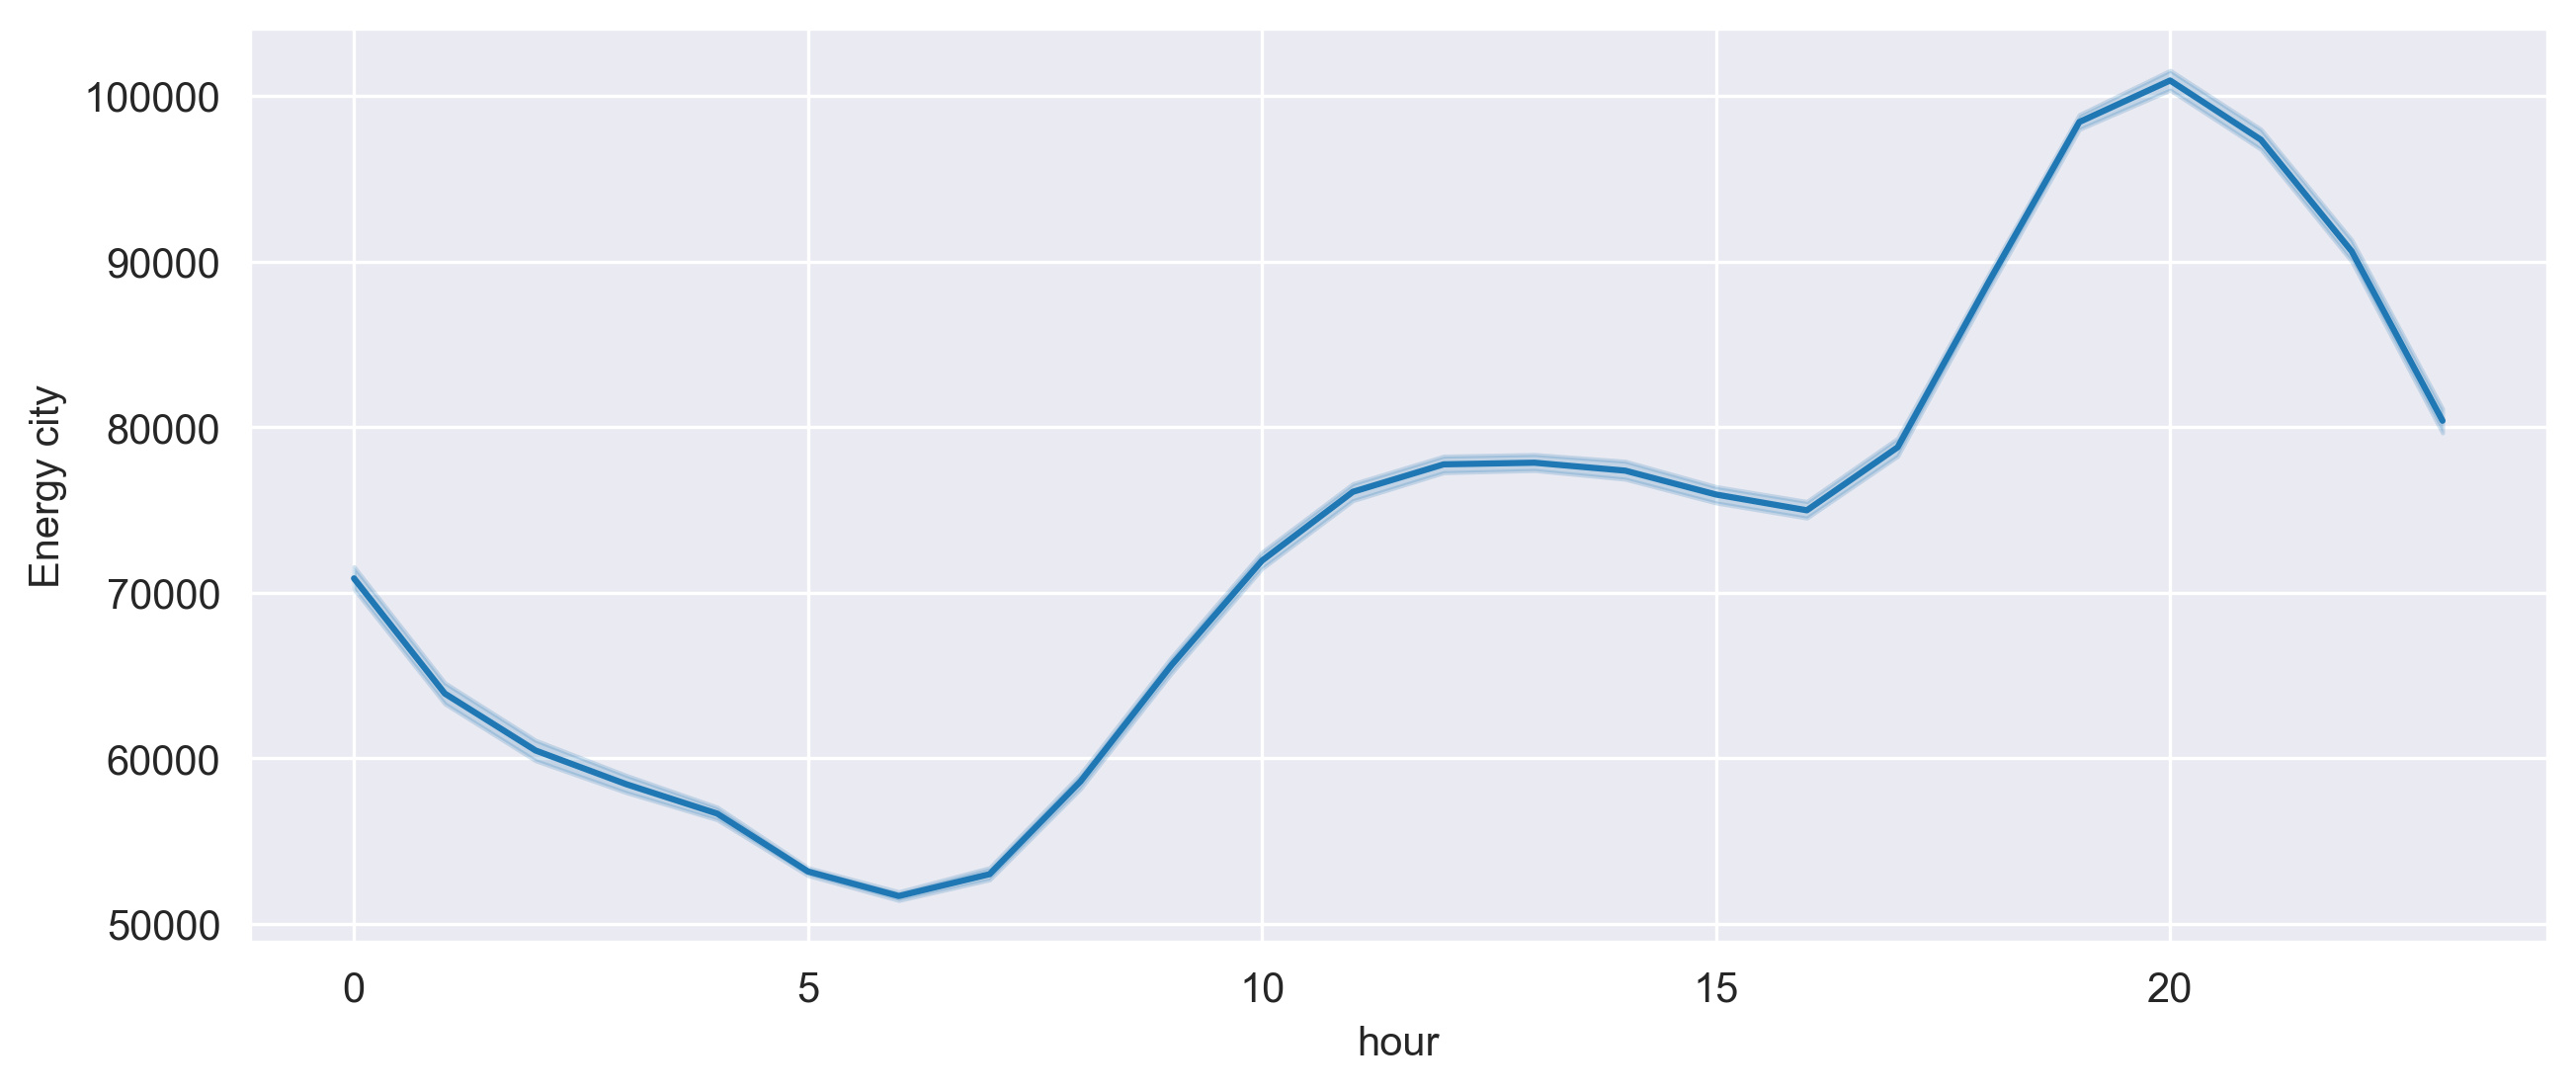

In [32]:
plt.figure(figsize=(10, 4), dpi=300)
sns.lineplot(data=train_data_preproc, x='hour', y='Energy city')

In [34]:
X = train_data.iloc[:, :-1]
y = train_data['Energy city']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [59]:
data_preprocessor = DataPreprocessor()
poly = PolynomialFeatures()
scaler = RobustScaler()

estimator_lgbm = LGBMRegressor(
    n_jobs=-1, 
    n_estimators=750, 
    learning_rate=0.1, 
    num_leaves=80, 
    max_depth=12, 
    max_bin=128, 
    reg_lambda=0.1,
    verbose=0
    ) 
estimator_pipeline = Pipeline([
    ('data', data_preprocessor),
    ('poly', poly),
    ('scaler', scaler),
    ('model', estimator_lgbm)
])

In [60]:
estimator_pipeline.fit(X_train, y_train)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

Pipeline(steps=[('data', DataPreprocessor()), ('poly', PolynomialFeatures()),
                ('scaler', RobustScaler()),
                ('model',
                 LGBMRegressor(max_bin=128, max_depth=12, n_estimators=750,
                               n_jobs=-1, num_leaves=80, reg_lambda=0.1,
                               verbose=0))])

In [61]:
cv_score = cross_val_score(estimator_pipeline, X_train, y_train, scoring='r2', n_jobs=-1)
print(f'Mean CV: {cv_score.mean()}')

Mean CV: 0.9867933484440492


In [38]:
feature_importances = pd.DataFrame({'importance': estimator_lgbm.feature_importances_}, index=data_preprocessor.transform(X_train).columns)
feature_importances

,importance
Temperature,2909
Humidity,3144
Wind Speed,2273
general diffuse flows,3435
diffuse flows,3301
month,411
weekday,1492
hour,1919
weekofyear,999
dayofyear,2394


In [81]:
datetime_preproc = DataPreprocessor()
spline = SplineTransformer()
estimator_lgbm = LGBMRegressor(n_jobs=-1, )

In [82]:
scoring = {
    'r2': 'r2',
    'mae': 'neg_mean_absolute_error'
}

def objective(params, pipeline, X, y):
    pipeline.set_params(**params),
    cv_scores = cross_validate(pipeline, X, y, scoring=scoring, cv=3, n_jobs=-1)
    loss_r2 = -1 * cv_scores['test_r2'].mean()
    mean_mae= cv_scores['test_mae'].mean()
    return {'loss': loss_r2, 'mae': mean_mae, 'params': params, 'status': STATUS_OK}

X_train_preproc = datetime_preproc.transform(X_train)
X_train_preproc = spline.fit_transform(X_train_preproc)
optimize_fn = partial(objective, pipeline=estimator_lgbm, X=X_train_preproc, y=y_train)

In [71]:
space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1200, 50)),
    'max_depth': scope.int(hp.quniform('max_depth', 6, 16, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 32, 256, 16)),
    'lerning_rate': hp.loguniform('learning_rate', np.log(0.1), np.log(0.7)),
    'reg_lambda': hp.uniform('reg_lambda', 0.1, 0.7),
    'max_bin': scope.int(hp.quniform('max_bin', 16, 128, 2))
}

trials = Trials()
tune_lgbm = fmin(
    fn=optimize_fn,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=np.random.default_rng(42),
    show_progressbar=True,
)

100%|██████████| 50/50 [14:31<00:00, 17.42s/trial, best loss: -0.9861450875318517]


In [46]:
tune_lgbm

{'learning_rate': 0.43703711924270117,
 'max_bin': 123.20113699232894,
 'max_depth': 11.0,
 'n_estimators': 600.0,
 'num_leaves': 81.81928850689252,
 'reg_lambda': 0.2674644956892518}

In [91]:
lgbm_model = LGBMRegressor(
    learning_rate=0.43703711924270117, 
    max_bin=123, 
    max_depth=11, 
    num_leaves=82, 
    n_estimators=600, 
    reg_lambda=0.2674644956892518
    )

datetime_preproc = DataPreprocessor()
spline = SplineTransformer()
scaler = RobustScaler()
pipeline = Pipeline([
    ('datetime', datetime_preproc),
    ('spline', spline),
    ('scaler', scaler),
    ('model', lgbm_model)
])

In [92]:
cv_score = cross_val_score(pipeline, X_train, y_train, cv=RepeatedKFold(n_splits=5, n_repeats=3, random_state=1), n_jobs=-1)
cv_score.mean()

0.9839209100032406

In [93]:
pipeline.fit(train_data.iloc[:, :-1], train_data['Energy city'])
r2_score(y_test, pipeline.predict(X_test))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6956
[LightGBM] [Info] Number of data points in the train set: 35118, number of used features: 152
[LightGBM] [Info] Start training from score 73303.699670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

0.9996819424609354

In [94]:
preds = pipeline.predict(test_data.drop('Energy city', axis=1))
test_data['Energy city'] = preds

In [95]:
test_data

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Energy city
0,12/31/2020/00:00,8.81577,73.80,0.08549,0.051,0.119,64375.948514
1,12/31/2020/00:10,8.66642,74.50,0.08549,0.070,0.085,67407.085754
4,12/31/2020/00:40,8.15863,75.70,0.08343,0.048,0.085,67265.996184
6,12/31/2020/01:00,7.87023,77.70,0.08240,0.048,0.096,60156.514477
7,12/31/2020/01:10,7.72088,78.20,0.08755,0.055,0.093,59117.757239
...,...,...,...,...,...,...,...
52398,12/29/2021/21:00,11.12400,65.49,0.08446,0.088,0.115,83504.878038
52402,12/29/2021/21:40,9.93950,71.10,0.08446,0.084,0.093,84739.295475
52404,12/29/2021/22:00,10.39270,68.49,0.08137,0.070,0.085,80682.293930
52405,12/29/2021/22:10,9.92920,70.10,0.08549,0.055,0.119,80373.289013


In [96]:
test_data.to_csv('submit.csv')